In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from PIL import Image
from torchvision import models, transforms,datasets
from torch.utils.data import DataLoader,Dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

torch.manual_seed(42) 
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42) 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class TestDataset(Dataset):
    def __init__(self, img_dir=None, transform=None,X=None,y=None):
        self.img_dir = img_dir
        self.transform = transform
        if img_dir: self.images = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]
        if X: self.X = X
        if y: self.y = y

    def __len__(self):
        if self.img_dir: return len(self.images)
        if self.X: return len(self.X)

    def __getitem__(self, idx):
        if self.img_dir: 
            image = Image.open(self.images[idx])
            if self.transform: image = self.transform(image)
            return image
        
        if self.X: 
            return self.X[idx],self.y[idx]

In [22]:
def DataPreprocess(train_PATH,val_PATH,test_PATH,batch_size):
    transform = transforms.Compose([
        # transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ,])
    
    train_data=datasets.ImageFolder(root=train_PATH, transform=transform)
    val_data=datasets.ImageFolder(root=val_PATH, transform=transform)
    test_data=TestDataset(img_dir=test_PATH, transform=transform)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=8)
    test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=False, num_workers=8)
    
    # 0:cat,1:dog
    # print(train_data.class_to_idx)
    # print(val_data.class_to_idx)
    return train_dataloader,val_dataloader,test_dataloader

def DataPreprocess2(batch_size):
    transform = transforms.Compose([transforms.ToTensor(), ])  
    train_dataset=datasets.cifar.CIFAR10(root='../CIFAR100/', train=True,transform=transform,download=True)
    
    X,y=[],[]
    for i in range(len(train_dataset)):
        temp=train_dataset[i]
        X.append(torch.stack((temp[0][0], temp[0][1], temp[0][2]),dim=0))
        y.append(temp[1])

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)
    train_dataset,val_dataset=TestDataset(X=X_train,y=y_train),TestDataset(X=X_val,y=y_val)
    train_loader=torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader=torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    test_dataset = datasets.cifar.CIFAR10(root='../CIFAR100/', transform=transform,train=False, download=True)
    test_loader= torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    return train_loader,val_loader,test_loader

In [23]:
class ConvNet(nn.Module):
    def __init__(self,num_classes):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # self.fc1 = nn.Linear(in_features=16 * 56 * 56, out_features=256)  # 假设输入图像大小为32x32
        self.fc1 = nn.Linear(in_features=32 * 32, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=num_classes)
        
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        bsz=x.shape[0]
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        # 展平特征图
        # x = x.view(-1, 16 * 56 * 56)
        x = x.view(bsz, -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

def train(model,epochs,train_loader,val_loader,test_loader,optimizer,criterion,tag=None):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')
        if epoch+1==epochs:break
        model.eval()
        correct = 0
        total = 0
        y_pred,y_true=[],[]
        with torch.no_grad():
            for images, labels in val_loader:
                y_true+=labels.cpu()
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                y_pred+=predicted.cpu()
                correct += (predicted == labels).sum().item()
        print(f'Accuracy on val set: {100 * correct / total}%')

        # 计算混淆矩阵
        cm = confusion_matrix(y_true,y_pred)

        # 使用seaborn的heatmap函数来可视化混淆矩阵
        sns.heatmap(cm, annot=True, fmt='d')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    model.eval()
    pred=[]
    with torch.no_grad():
        if tag=='catdog':
            for images in test_loader:
                images = images.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                pred.extend(predicted.cpu().numpy())
            # for _ in range(len(pred)):pred[_]='cat' if _==0 else 'dog'
            res=pd.DataFrame(columns=['label'],data=pred)
            res.to_csv('./res.csv')    
            torch.save(model,'./model.pth')
        elif tag=='cifar10':
            y_pred,y_true=[],[]
            for images, labels in test_loader:
                y_true+=labels.cpu()
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                y_pred+=predicted.cpu()
                correct += (predicted == labels).sum().item()
            print(f'Accuracy on test set: {100 * correct / total}%')

            # 计算混淆矩阵
            cm = confusion_matrix(y_true,y_pred)

            # 使用seaborn的heatmap函数来可视化混淆矩阵
            sns.heatmap(cm, annot=True, fmt='d')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 1.8538370203971863
Accuracy on val set: 44.45%


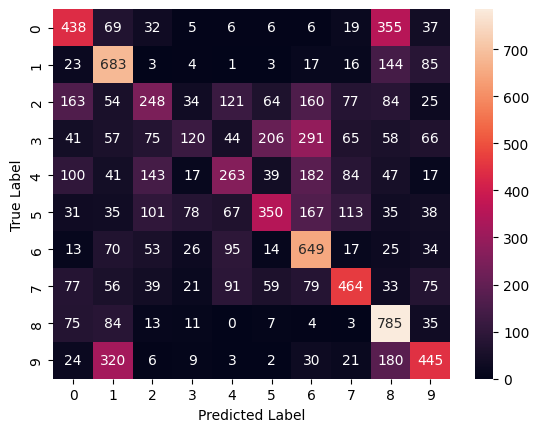

Epoch 2, Loss: 1.5629384529590606
Accuracy on val set: 50.9%


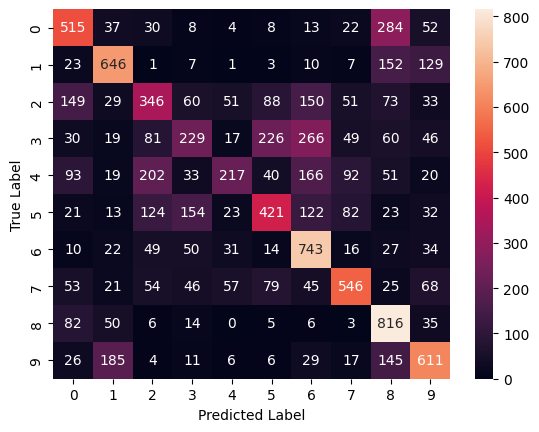

Epoch 3, Loss: 1.4414619850635528
Accuracy on val set: 51.98%


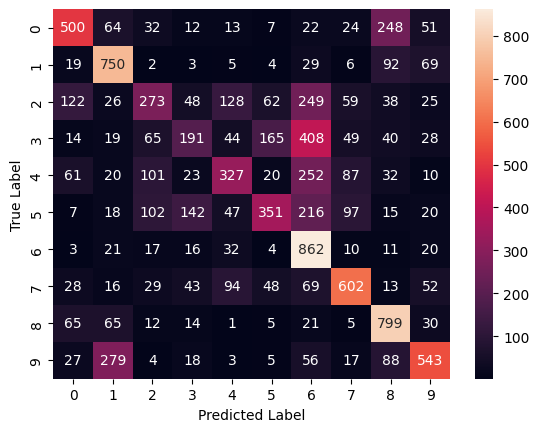

Epoch 4, Loss: 1.3683251324653625
Accuracy on val set: 54.12%


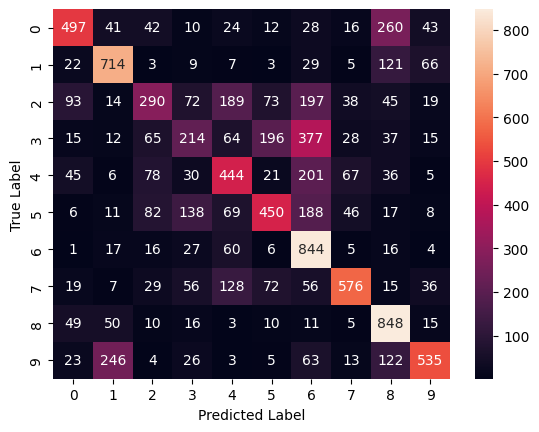

Epoch 5, Loss: 1.3148218565940857
Accuracy on val set: 55.98%


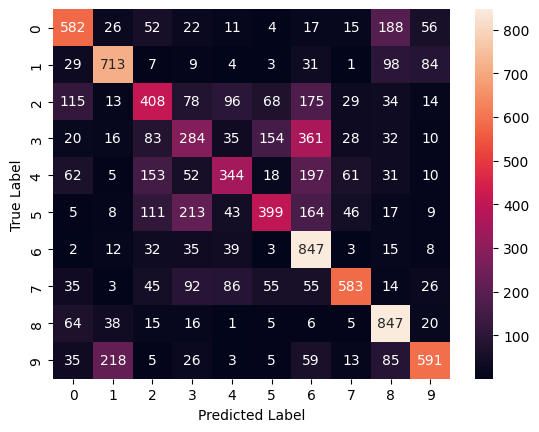

Epoch 6, Loss: 1.2774097510814666
Accuracy on val set: 56.98%


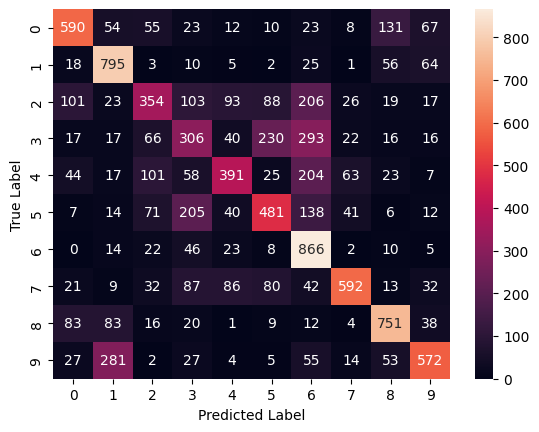

Epoch 7, Loss: 1.234203078174591
Accuracy on val set: 58.92%


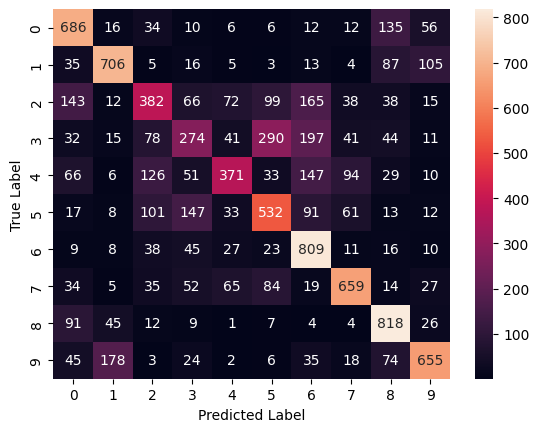

Epoch 8, Loss: 1.2048933845043182
Accuracy on val set: 57.8%


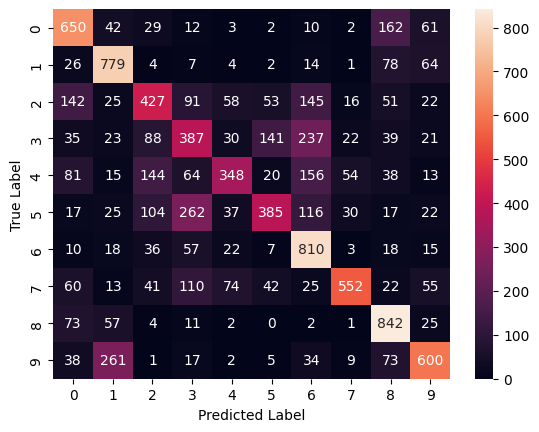

Epoch 9, Loss: 1.175984188079834
Accuracy on val set: 59.32%


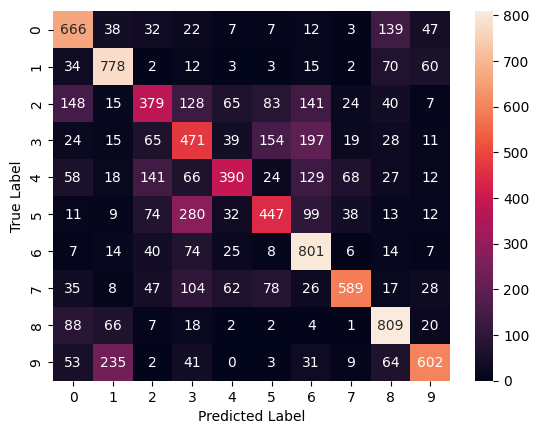

Epoch 10, Loss: 1.1508756514072418
Accuracy on test set: 59.75%


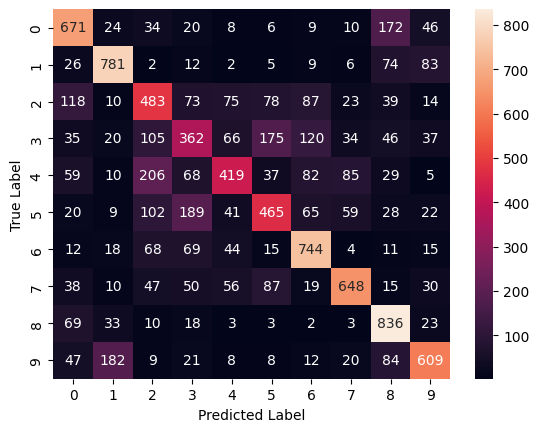

In [24]:
# model=ConvNet(num_classes=2).to(device)
model=ConvNet(num_classes=10).to(device)

epoch=10
batch_size = 32
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train_loader,val_loader,test_loader=DataPreprocess('./datasets/train','./datasets/val','./datasets/test',batch_size)
train_loader,val_loader,test_loader=DataPreprocess2(batch_size)
train(model,epoch,train_loader,val_loader,test_loader,optimizer,criterion,tag='cifar10')